<a href="https://colab.research.google.com/github/adityasaich/sasi_btp/blob/main/Copy_of_sasi_btp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
id = '18xGNPuvbXGSN97g0CzI1tIBl81zJrToF'

In [ ]:
def deviationTransform(arr):
  d = np.std(arr)
  return [0,d]
def minMaxTransform(arr):
  min = np.min(arr)
  max = np.max(arr)
  return [min,max-min]

In [ ]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('dataset.csv')  
df_input = pd.read_csv('dataset.csv')
#df_input = df_input.sample(n=50000)

In [ ]:
#pre-processing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
df_input = df_input[df_input['Area'] > 0 ]
df_input = df_input[df_input['Production'] > 0 ]
df_input["ProductionPerArea"] = ((df_input["Production"])/(df_input["Area"]))
#dropping columns which are not used
df_input = df_input.drop(columns=['State_Name','Production','Area'])
#replace empty strings with nan
df_input = df_input.replace(r'^\s*$', np.NaN, regex=True)
#drop null values
df_input = df_input.dropna()


In [ ]:
categorical_columns = ['District_Name', 'Crop' ,'Season']
#label encoder dict
labels_dict = {}
#scaling dict
scaling_dict = {}
for column in categorical_columns:
  le = LabelEncoder()
  le.fit(df_input[column])
  df_input[column] = le.transform(df_input[column])
  labels_dict[column] = list(le.classes_)
  scaling_params = minMaxTransform(np.array(df_input[column]))
  df_input[column] = (df_input[column] - scaling_params[0])/scaling_params[1]
  scaling_dict[column] = scaling_params
scaling_params = deviationTransform(np.array(df_input['Crop_Year'])) 
scaling_dict['Crop_Year'] = scaling_params
df_input['Crop_Year'] = (df_input['Crop_Year'] - scaling_params[0])/scaling_params[1]
scaling_params = deviationTransform(np.array(df_input['ProductionPerArea']))
df_input['ProductionPerArea'] = (df_input['ProductionPerArea'] - scaling_params[0])/scaling_params[1]
scaling_dict['ProductionPerArea'] = scaling_params
p1 = np.percentile(np.array(df_input['ProductionPerArea']), 25)
p2 = np.percentile(np.array(df_input['ProductionPerArea']), 99)
df_input = df_input[df_input['ProductionPerArea'] > p1]
df_input = df_input[df_input['ProductionPerArea'] < p2]

count    176739.000000
mean          0.006262
std           0.013179
min           0.000646
25%           0.001065
50%           0.001754
75%           0.003979
max           0.101400
Name: ProductionPerArea, dtype: float64
0.01507081130520552


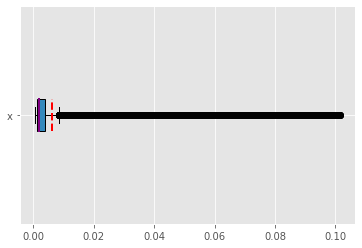

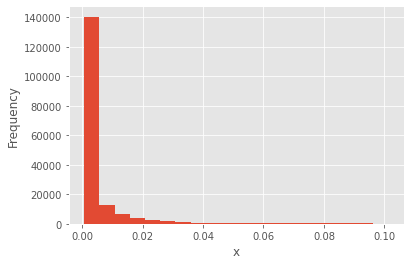

In [ ]:
x = df_input['ProductionPerArea']
print(x.describe())
print(np.percentile(np.array(x), 90))
import matplotlib.pyplot as plt
plt.style.use('ggplot')
fig, ax = plt.subplots()
ax.boxplot((x), vert=False, showmeans=True, meanline=True,
           labels=('x'), patch_artist=True,
           medianprops={'linewidth': 2, 'color': 'purple'},
           meanprops={'linewidth': 2, 'color': 'red'})
plt.show()
hist, bin_edges = np.histogram(x, bins=20)
fig, ax = plt.subplots()
ax.hist(x, bin_edges, cumulative=False)
ax.set_xlabel('x')
ax.set_ylabel('Frequency')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
df_small = df_input
df_small.columns.name = None
df=df_small
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1], test_size=0.33, random_state=42)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
def classify(clf,x_train,x_test,y_train,y_test):
  clf.fit(x_train,y_train)
  y_pred = clf.predict(x_test)
  #print(y_pred)
  y_train_pred = clf.predict(x_train)
  print(mean_squared_error(y_train, y_train_pred))
  print(mean_squared_error(y_test, y_pred))
  print(r2_score(y_test,y_pred))
  y_pred = np.array(y_pred)
  y_test = np.array(y_test)
  for i in range(y_test.size):
    if(y_test[i]>1 and y_test[i]<1):
      print(i,y_test[i],y_pred[i])

In [ ]:
from sklearn.ensemble import RandomForestRegressor
regresser = RandomForestRegressor(n_estimators = 10 ,random_state = 0)
print("\t\t\t random-forest classifier")
classify(regresser,x_train,x_test,y_train,y_test)

			 random-forest classifier
0.11629413656651696
0.5882025929420063
0.22717264288000738


In [ ]:
#linear regression
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
print("\t\t\t linear-regression classifier")
classify(reg,x_train,x_test,y_train,y_test)

			 linear-regression classifier
0.00015706748090237865
0.00015341275411539645
0.10176956008491334


In [ ]:
from sklearn.linear_model import BayesianRidge
clf = BayesianRidge()
classify(clf,x_train,x_test,y_train,y_test)

0.0001570674824676581
0.00015341261606768828
0.10177036835313291


In [ ]:
json_params = {}
json_params['labels'] = labels_dict
json_params['scaling'] = scaling_dict

In [ ]:
from sklearn.linear_model import ElasticNet
regr = ElasticNet(random_state=0)
classify(regr,x_train,x_test,y_train,y_test)

0.0001751157244405434
0.00017081013064008805
-9.193936634943611e-05


In [ ]:
from sklearn.tree import DecisionTreeRegressor 
regressor = DecisionTreeRegressor(random_state = 0) 
classify(regressor,x_train,x_test,y_train,y_test)



7.474064400844894e-08
1.0065166775097714
-0.3224416775968988


In [ ]:
from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf')
classify(regressor,x_train,x_test,y_train,y_test)

0.0021742411950972144
0.0021811412660171455
-11.770564547833176


In [ ]:
from sklearn.linear_model import Lasso
model_lasso = Lasso(alpha=1)
classify(model_lasso,x_train,x_test,y_train,y_test)



0.0001751157244405434
0.00017081013064008805
-9.193936634943611e-05


In [ ]:
from sklearn.linear_model import Ridge
krr = Ridge(alpha=1.0)
classify(krr,x_train,x_test,y_train,y_test)


0.00015706748115701296
0.00015341269806294871
0.10176988827154343


In [ ]:
from sklearn.linear_model import LogisticRegression  
classifier= LogisticRegression(random_state=0)  
classify(classifier,x_train,x_test,y_train,y_test)


ValueError: ignored

In [ ]:
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

np.random.seed(1)


def f(x):
    """The function to predict."""
    return x * np.sin(x)


# ----------------------------------------------------------------------
#  First the noiseless case
X = np.atleast_2d([1.0, 3.0, 5.0, 6.0, 7.0, 8.0]).T

# Observations
y = f(X).ravel()

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
x = np.atleast_2d(np.linspace(0, 10, 1000)).T

# Instantiate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
classify(gp,x_train,x_test,y_train,y_test)
